# Algorithms for Optimizations
## Chapter 3. Bracketing

In [1]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,sympy,tqdm,matplotlib

Python implementation: CPython
Python version       : 3.7.8
IPython version      : 7.19.0

numpy     : 1.18.4
scipy     : 1.5.2
sympy     : 1.6.2
tqdm      : 4.51.0
matplotlib: 3.3.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.4.0-176-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit



In [2]:
import sys
assert sys.version_info >= (3, 7)

In [3]:
import time
import numpy as np
import scipy as sp
import sympy as sy
import matplotlib.pyplot as plt

from tqdm import tqdm

In [4]:
def plot_method(function, method, title, values=np.arange(-1.5, 1.5, 0.001), figsize=(15, 10), **method_kwargs):    
    fig, ax = plt.subplots()
    fig.set_size_inches(*figsize)

    ax.plot(values, function(values), color='k')
    if callable(method):
        tic = time.time()
        for candidate in method(function, **method_kwargs):
            ax.plot(candidate, function(candidate), marker='x', markersize=15)
        toc = time.time()
        print(f"[INFO] Estimated time: {toc - tic:.6f} sec")
    else:
        ax.plot(method, function(method), marker='o', markersize=15)
        
    ax.set_ylim([-1.0, 1.0])
    ax.set_title(title)
    
    plt.show()

#### Bracketing assumes unimodality
* Page 36 (Algorithm 3.1)

In [5]:
def f(x):
    return x * (x - 1) * (x + 1)

In [6]:
x = sy.symbols("x")
func = x * (x - 1) * (x + 1)
func

x*(x - 1)*(x + 1)

In [7]:
sy.diff(func, x)

x*(x - 1) + x*(x + 1) + (x - 1)*(x + 1)

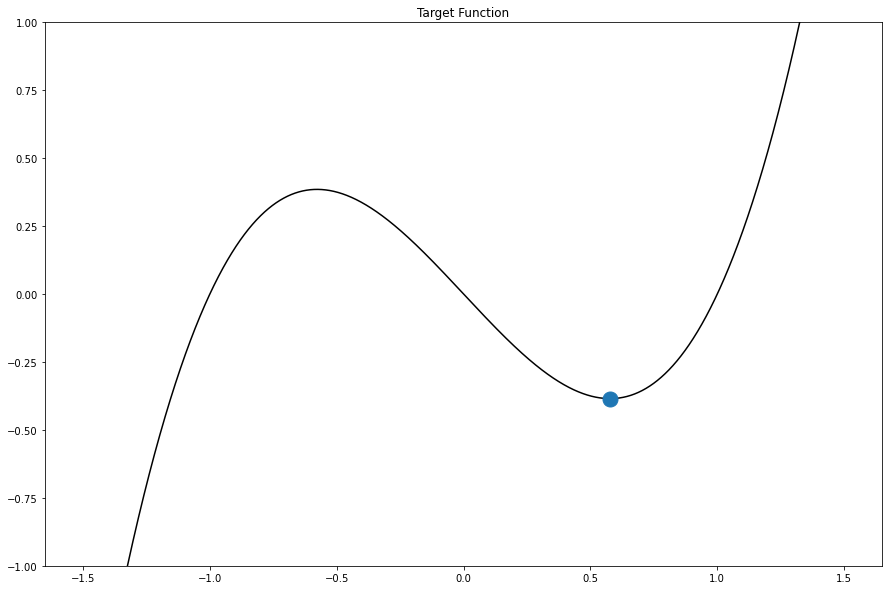

[INFO] Local minimum is at x=0.577350 with value f(x)=-0.384900


In [8]:
local_minimum = 1 / np.sqrt(3)
plot_method(f, local_minimum, "Target Function")
print(f"[INFO] Local minimum is at x={local_minimum:.6f} with value f(x)={f(local_minimum):.6f}")

In [9]:
def bracket_minimum(f, x=0, s=1e-2, k=2.0):
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    
    while True:
        c, yc = b + s, f(b + s)
        if yc > yb:
            return (a, c) if a < c else (c, a)
        a, ya, b, yb = b, yb, c, yc
        s *= k

[INFO] Estimated time: 0.001093 sec


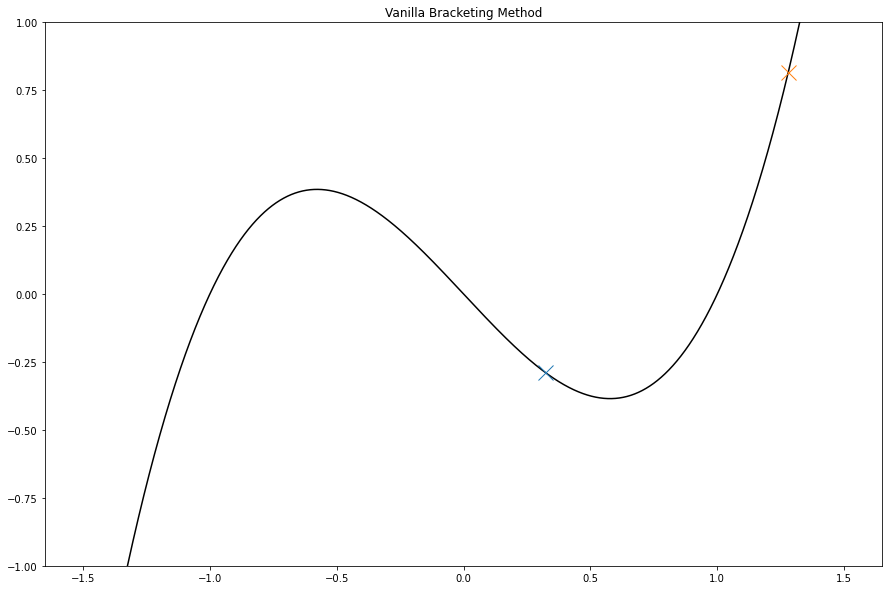

In [10]:
plot_method(f, bracket_minimum, "Vanilla Bracketing Method")

In [11]:
bracket_minimum(f)

(0.32, 1.28)

#### Fibonacci search
* Page 39 (Algorithm 3.2)

In [12]:
def fibonacci_search(f, a, b, n, eps=1e-5):
    phi = (1 + np.sqrt(5)) / 2 # golden ratio
    
    s = (1 - np.sqrt(5)) / (1 + np.sqrt(5))
    rho = 1 / (phi * (1 - s**(n + 1)) / (1 - s**n))
    d = rho * b + (1 - rho) * a
    yd = f(d)
    
    for i in range(1, n):
        if i == n - 1:
            c = eps * a + (1 - eps) * d
        else:
            c = rho * a + (1 - rho) * b
        yc = f(c)
        if yc < yd:
            b, d, yd = d, c, yc
        else:
            a, b = b, c
        rho = 1/ (phi * (1 - s**(n - i + 1)) / (1 - s**(n - i)))
    return (a, b) if a < b else (b, a)

[INFO] Estimated time: 0.001228 sec


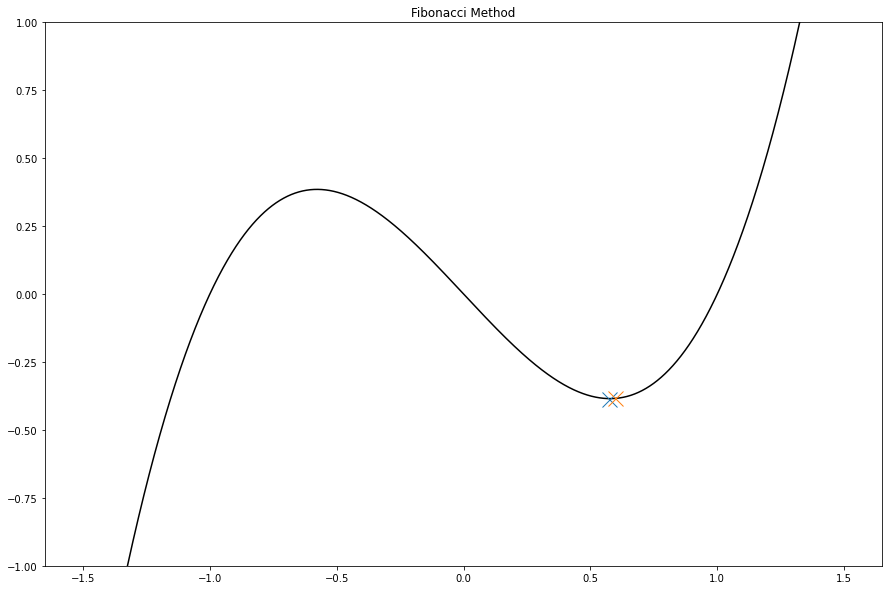

In [13]:
plot_method(f, fibonacci_search, "Fibonacci Method", a=-1., b=1., n=10)

In [14]:
fibonacci_search(f, -1., 1., 10)

(0.5730337078651684, 0.595505617977528)

#### Golden section search
* Page 41 (Algorithm 3.3)
  * Guaranteed to converged to within $\epsilon$ such taht $n = \frac{(b - a)}{(\epsilon \log{\phi})}$ iterations.

In [15]:
def golden_section_search(f, a, b, n):
    phi = (1 + np.sqrt(5)) / 2 # golden ratio
    
    rho = phi - 1
    d = rho * b + (1 - rho) * a
    yd = f(d)
    for i in range(1, n):
        c = rho * a + (1 - rho) * b
        yc = f(c)
        if yc < yd:
            b, d, yd = d, c, yc
        else:
            a, b = b, c
    return (a, b) if a < b else (b, a)

[INFO] Estimated time: 0.001375 sec


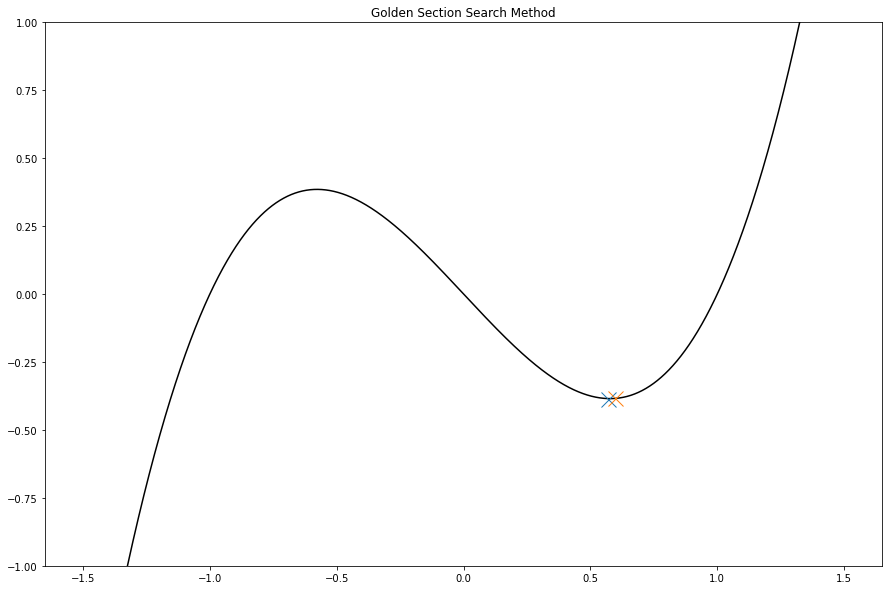

In [16]:
plot_method(f, golden_section_search, "Golden Section Search Method", a=-1., b=1., n=10)

In [17]:
golden_section_search(f, -1., 1., 10)

(0.570436517504837, 0.5967477524976867)

#### Quadratic fit search
* Page 44 (Algorithm 3.4)
  * Needs three points.
  * Generally faster than golden section search method.
  * Requires safeguards when the next point is very close to other points.

In [18]:
def quadratic_fit_search(f, a, b, c, n, eps=1e-5):
    ya, yb, yc = f(a), f(b), f(c)
    for i in range(1, n-2):
        x = 0.5 * (ya * (b**2 - c**2) + yb * (c**2 - a**2) + yc * (a**2 - b**2)) / (ya * (b - c) + yb * (c - a) + yc * (a - b) + eps)
        yx = f(x)
        if x > b:
            if yx > yb:
                c, yc = x, yx
            else:
                a, ya, b, yb = b, yb, x, yx
        elif x < b:
            if yx > yb:
                a, ya = x, yx
            else:
                c, yc, b, yb = b, yb, x, yx
    return (a, b, c)

[INFO] Estimated time: 0.001543 sec


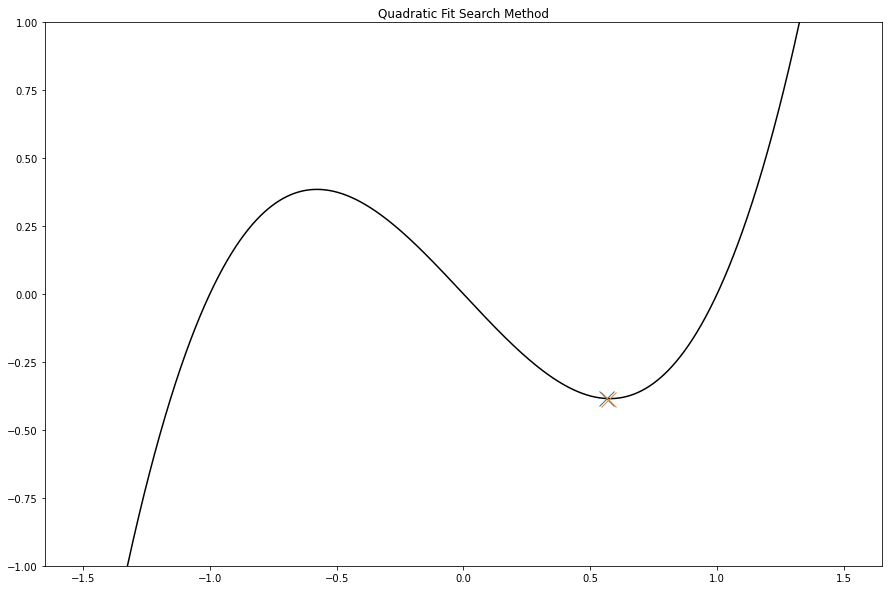

In [19]:
plot_method(f, quadratic_fit_search, "Quadratic Fit Search Method", a=-0.5, b=0, c=1.5, n=10)

In [20]:
quadratic_fit_search(f, -0.5, 0., 1.5, 10)

(0.5604448806944052, 0.5685256990112503, 1.5)

#### Shubert-Piyavskii method
* Page 47 (Algorithm 3.5)
  * Finds global minimum.
  * Needs to set valid Lipschitz constant $l$, and sensitive to this constant.

In [21]:
class Pt:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
def _get_sp_intersection(A: Pt, B: Pt, l: float) -> Pt:
    t = ((A.y - B.y) - l * (A.x - B.x)) / (2 * l)
    return Pt(A.x + t, A.y - t * l)

def shubert_piyavskii(f, a, b, l, eps=1e-5, delta=0.01):
    m = (a + b) / 2
    A, M, B = Pt(a, f(a)), Pt(m, f(m)), Pt(b, f(b))
    pts = [A, _get_sp_intersection(A, M, l), M, _get_sp_intersection(M, B, l), B]
    diff = np.inf
    while diff > eps:
        i = np.argmin([P.y for P in pts])
        P = Pt(pts[i].x, f(pts[i].x))
        diff = P.y - pts[i].y
        
        P_prev = _get_sp_intersection(pts[i - 1], P, l)
        P_next = _get_sp_intersection(P, pts[i + 1], l)
        
        del pts[i]
        pts.insert(i, P_next)
        pts.insert(i, P)
        pts.insert(i, P_prev)
    
    intervals = []
    i = 2 * np.argmin([P.y for P in pts[::2]]) - 1
    for j in range(1, len(pts), 2):
        if pts[j].y < pts[i].y:
            dy = pts[i].y - pts[j].y
            x_lo = max(a, pts[j].x - dy / l)
            x_hi = min(b, pts[j].x + dy / l)
            if intervals:
                if intervals[-1][1] + delta >= x_lo:
                    intervals[-1] = (intervals[-1][0], x_hi)
            else:
                intervals.append((x_lo, x_hi))
    return intervals[-1]

[INFO] Estimated time: 0.117872 sec


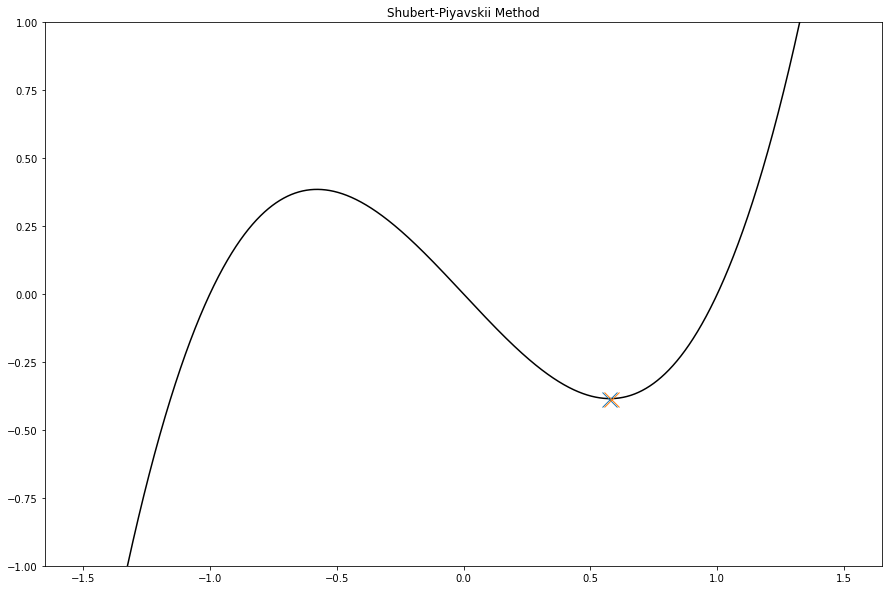

In [22]:
plot_method(f, shubert_piyavskii, "Shubert-Piyavskii Method", a=-1., b=1., l=1.5)

In [23]:
shubert_piyavskii(f, a=-1., b=1., l=1., eps=1e-5)

(0.5773672629087525, 0.5773672630616746)

#### Bisection method
* Page 50 (Algorithm 3.6 ~ Algorithm 3.7)
  * Method to find roots of a function.
  * Requires a bracket $[a, b]$ where at least one root is known to exist.
  * Converges within $\epsilon$ of $x^{*}$ within $\log_{2}{\frac{\lvert(b - a)\rvert}{\epsilon}}$.
  * Used to explore the point where $f'(x)=0$.
  * Hard to specify starting interval when two or more roots are adjacent to each other.

In [24]:
def bisection(fprime, a, b, eps=1e-5):
    if a > b:
        a, b = b, a
    ya, yb = fprime(a), fprime(b)
    if ya == 0:
        b = a
    if yb == 0:
        a = b
    
    while b - a > eps:
        x = (a + b) / 2
        y = fprime(x)
        if y == 0:
            a, b = x, x
        elif np.sign(y) == np.sign(ya):
            a = x
        else:
            b = x
    return (a, b)

In [25]:
def bracket_sign_change(fprime, a, b, k=2):
    if a > b:
        a, b = b, a
    center, half_width = (b + a) / 2, (b - a) / 2
    while fprime(a) * fprime(b) > 0:
        half_width *= k
        a = center - half_width
        b = center - half_width
    return (a, b)

In [26]:
def fprime(x):
    return x * (x - 1) + x * (x + 1) + (x - 1) * (x + 1)

[INFO] Estimated time: 0.001260 sec


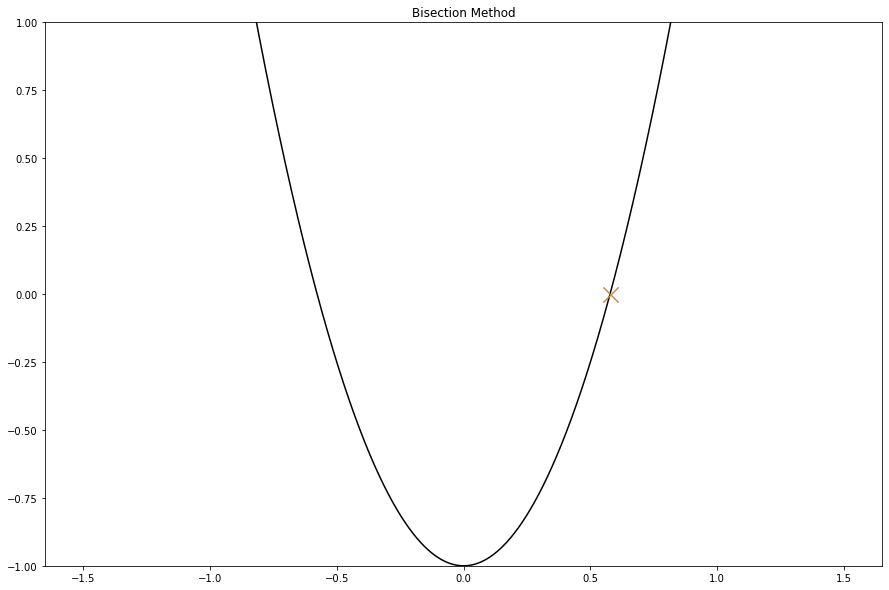

In [27]:
plot_method(fprime, bisection, "Bisection Method", a=0.5, b=1.5)

In [28]:
bisection(fprime, 0.5, 1.5)

(0.5773468017578125, 0.5773544311523438)